In [1]:
# import all packages
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# set display options
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',200)
pd.set_option('display.width',200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
kwargs = dict(skipinitialspace=False,engine='c',encoding='ISO-8859-1')


import gc

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import confusion_matrix,classification_report

## Read in the main data file

In [2]:
%%time

df = pd.read_csv('../10262021_Update_Eng/yoy_hp_dem_util_cahps.csv')
print(df.shape)


(4995430, 190)
Wall time: 2min 37s


## Review Potential Target Columns

In [3]:
# 100104: Diabetes - EYE
# 100107: Diabetes - Kidney
# 101803: Controlling high blood pressure
# 201180: Diabetes Adherence
# 999998: Diabetes Blood Sugar Controlled
# TARGET_COLS = ['100104','100107','101803','201180','999998','104201','107110']
TARGET_COLS = ['201181','999998','201183','201182']
df[TARGET_COLS].describe()

,201181,999998,201183,201182
count,1950171.000,739880.000,582169.000,686252.000
mean,0.881,0.525,0.821,0.863
std,0.324,0.499,0.383,0.344
min,0.000,0.000,0.000,0.000
25%,1.000,0.000,1.000,1.000
50%,1.000,1.000,1.000,1.000
75%,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000


In [4]:
# print(*list(df.columns),sep='\n')

In [5]:
cols = [
'MEDICARE_NUMBER',
# 'Member_ID',
# 'Eff_Date',
# 'Term_Date',
# 'Mbr_Mths',
# 'Contract_Number',
# 'PBP',
# 'Product',
# 'CMS_County',
# 'CMS_State',
# 'NEW_REGION',
# 'MA_Territory',
# 'DOB',
'Age',
'Gender',
# 'Zip',
# 'FIPS',
'Plan_Type',
# 'dual_Status',
# 'PCP_Name',
# 'PCP_Tax_ID',
# 'GroupName',
# 'GroupNumber',
# 'GroupSegment',
# 'GroupSegmentName',
# 'TRR_Parent_Name',
# 'TOH_Name',
# 'Recruiter_Name',
# 'Writing_Agent_Name',
# 'Sales_Channel',
# 'New_Market',
'SNP',
'LIS_Flag',
# 'Enroll_Status',
# 'Issued_Status',
# 'Group_Status',
# 'AEP2018_Denom',
# 'AEP2018_Lapse',
'YEAR',
# 'AEP2019_Denom',
# 'AEP2019_Lapse',
# 'AEP2020_Denom',
# 'AEP2020_Lapse',
# 'AEP2021_Denom',
# 'AEP2021_Lapse',
'yoys',
# 'has_dem',
# 'SRC_MEMBER_ID_x',
# 'RUNYEAR',
# 'ITERATION',
# 'GNC_Den_Final',
# 'GACQ_Den_Final',
# 'HPCS_Den_Final',
# 'GNP_Den_Final',
# 'CC_Den_Final',
# 'Plan_R_Den_Final',
# 'Care_R_Den_Final',
# 'RX_R_Den_Final',
# 'GNC',
# 'GACQ',
# 'HPCS',
# 'GNP',
# 'CC',
# 'Plan_R',
# 'Care_R',
# 'RX_R',
# 'RX_Rating_Class',
# 'CARE_Rating_Class',
# 'PLAN_Rating_Class',
# 'GNC_Class',
# 'GCQ_Class',
# 'CS_Class',
# 'CC_Class',
# 'GNP_Class',
# 'PERIOD_STUDIED',
# 'dem_year',
# 'has_cahps',
# 'HICN_NBR',
# '100104',
# '100107',
# '101201',
# '101603',
# '102401',
# '104201',
# '107107',
# '107110',
# '107125',
# '107126',
# '107127',
# '201180',
# '201181',
# '201182',
# '201183',
# '201184',
# '201507',
# '999998',
# 'HP_YEAR',
# '101803',
# '600070',
# 'has_hp',
# 'SRC_MEMBER_ID_y',
# 'EMERG_TRANSACTIONS',
# 'PCP_TRANSACTIONS',
# 'SPCLST_TRANSACTIONS',
# 'IP_TRANSACTIONS',
'EMERG_VISITS',
'PRIMARY_CARE_VISITS',
'SPCLST_VISITS',
'IP_VISITS',
# 'PREVENTIVE_CARE_VISITS',
'EMERG_BENEFIT_PAID_AMT',
'PCP_BENEFIT_PAID_AMT',
'SPCLST_BENEFIT_PAID_AMT',
'IP_BENEFIT_PAID_AMT',
'EMERG_MBR_PAID_AMT',
'PCP_MBR_PAID_AMT',
'SPCLST_MBR_PAID_AMT',
'IP_MBR_PAID_AMT',
# 'PAR_MED_CLAIM_COUNT',
# 'NONPAR_MED_CLAIM_COUNT',
# 'PAR_MED_VISITS',
# 'NONPAR_MED_VISITS',
# 'PAR_MED_BENEFIT_PAID_AMT',
# 'NONPAR_MED_BENEFIT_PAID_AMT',
# 'PAR_MED_MBR_PAID_AMT',
# 'NONPAR_MED_MBR_PAID_AMT',
'AETNA_MED_PAID_AMT',
'MBR_MED_PAID_AMT',
# 'TOTAL_MED_COST',
# 'MBR_MED_DEDUCTIBLE_PAID_AMT',
# 'PAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
# 'NONPAR_MED_MBR_DEDUCTIBLE_PAID_AMT',
'AMBULANCE_CLAIM_COUNT',
# 'AMBULANCE_EVENT_COUNT',
# 'BEHAVIORAL_HEALTH_CLAIM_COUNT',
# 'BEHAVIORAL_HEALTH_VISITS',
# 'OP_TRANSACTIONS',
# 'OP_VISITS',
# 'OP_BENEFIT_PAID_AMT',
# 'OP_MBR_PAID_AMT',
# 'DR_TRANSACTIONS',
# 'DR_VISITS',
# 'DR_BENEFIT_PAID_AMT',
# 'DR_MBR_PAID_AMT',
# 'VISION_TRANSACTIONS',
# 'VISION_VISITS',
# 'TOTAL_ALLOWED_VISION',
# 'BENEFIT_PAID_VISION',
# 'MEM_PAID_VISION',
# 'PAR_AMT_VISION',
# 'NONPAR_AMT_VISION',
# 'PREV_TRANSACTIONS_DENTAL',
# 'COMP_TRANSACTIONS_DENTAL',
# 'PREV_ALLOWED_DENTAL',
# 'COMP_ALLOWED_DENTAL',
# 'TOTAL_ALLOWED_DENTAL',
# 'PREV_BENEFIT_PAID_DENTAL',
# 'COMP_BENEFIT_PAID_DENTAL',
# 'BENEFIT_PAID_DENTAL',
# 'PREV_MEM_PAID_DENTAL',
# 'COMP_MEM_PAID_DENTAL',
# 'MEM_PAID_DENTAL',
# 'PAR_AMT_DENTAL',
# 'NONPAR_AMT_DENTAL',
# 'PAR_VISITS_DENTAL',
# 'NONPAR_VISITS_DENTAL',
# 'TOTAL_ENCOUNTER_ALLOWED_HEARING',
# 'BENEFIT_ENCOUNTER_PAID_HEARING',
# 'MEM_ENCOUNTER_PAID_HEARING',
# 'TOTAL_ALLOWED_HEARING',
# 'BENEFIT_PAID_HEARING',
# 'MEM_PAID_HEARING',
# 'PAR_AMT_HEARING',
# 'NONPAR_AMT_HEARING',
# 'Order_Count_OTC',
# 'Call_or_Claim_Orders_OTC',
# 'Online_Orders_OTC',
# 'Store_Orders_OTC',
# 'Total_AMT_OTC',
# 'Call_or_Claim_AMT_OTC',
# 'Online_AMT_OTC',
# 'Store_AMT_OTC',
'Benefit_Paid_Amt_OTC',
'Mbr_Paid_Amt_OTC',
# 'has_util',
'PLAN',
# 'PLAN_YOY',
# 'yoy_Full_eligible',
# 'yoy_Part_C_eligible',
# 'yoy_Part_D_eligible'
]
cols.extend(TARGET_COLS)
cols = list(set(cols))
yoy_cols = [
"PLAN","yoys",
# "CONTRACT",
# "PBP",
# "CY_PBPNAME",
# "CY_PRODUCT",
# "PLANTYPE",
# "CY_RENEWALTYPE",
# "CY_OPENACCESS",
# "REGION",
# "MARKET",
# "PLANGEONAME",
# "STATE",
# "CY_PRIMEPLAN",
# "CY_DEDUCTIBLEHMOINN",
# "CY_DEDUCTIBLEPPOANNUAL",
# "CY_DEDUCTIBLEPOSOON",
# "CY_HIGHDEDUCTIBLE",
# "CY_MOOPINN",
# "CY_MOOPCOMBINED",
# "CY_MOOPOON",
# "CY_PREMIUM",
# "CY_PARTBGIVE",
# "CY_INPATIENTSTAYMC",
# "CY_SNF",
# "CY_EMERGENCY",
# "CY_URGENTLYNEEDEDCARE",
# "CY_PCP_MIN",
# "CY_PCP",
# "CY_PCPREASONCD",
# "CY_CHIROPRACTICROUTINE",
# "CY_OCCUPATIONALTHERAPY",
# "CY_PHYSICIANSPECIALIST",
# "CY_DIAGNOSTICPROC",
# "CY_LAB_MIN",
# "CY_LAB",
# "CY_LABREASONCD",
# "CY_DIAGNOSTICRADIOLOGYCT",
# "CY_OUTPATIENTHOSP_MIN",
# "CY_OUTPATIENTHOSP",
# "CY_OUTPATIENTHOSPREASONCD",
# "CY_OUTPATIENTHOSPOBSERVATION_MIN",
# "CY_OUTPATIENTHOSPOBSERVATION",
# "CY_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "CY_ASC",
# "CY_DIALYSIS",
# "CY_ACUPUNCTURE",
# "CY_OTCALLOWANCE",
# "CY_OTCPERIODICITYNMC",
# "CY_FITNESSVENDOR",
# "CY_TELEMONITORING",
# "CY_NURSINGHOTLINE",
# "CY_DENTALBENEFITADMINTYPE",
# "CY_PREVENTIVEDENTALBENTYPE",
# "CY_ORALFREQ",
# "CY_DENTALXRAYSFREQ",
# "CY_PREVDENTALALLOWANCE",
# "CY_PREVDENTALALLOWANCEFREQ",
# "CY_COMPREHENSIVEDENTALNMCBENTYPE",
# "CY_COMPDENTALALLOWANCE",
# "CY_EYEEXAMSMC",
# "CY_EYEEXAMSROUTINE",
# "CY_EYEWEARBENEFITADMINTYPE",
# "CY_EYEWEARNMCBENTYPE",
# "CY_EYEGLASSESFREQ",
# "CY_EYEWEARALLOWANCE",
# "CY_EYEWEARALLOWANCEFREQ",
# "CY_HEARINGEXAMROUTINEFREQ",
# "CY_HEARINGEXAMMC",
# "CY_HEARINGEXAMROUTINE",
# "CY_HEARINGAIDFITTING",
# "CY_HEARINGAIDBENEFITADMINTYPE",
# "CY_HEARINGAIDBENTYPE",
# "CY_HEARINGAIDALLFREQ",
# "CY_HEARINGAIDALLOWANCE",
# "CY_HEARINGAIDALLOWANCETYPE",
# "CY_HEARINGAIDALLOWANCEFREQ",
# "CY_FORMULARYNAME",
# "CY_RXDEDUCTIBLE",
# "CY_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "CY_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "CY_NETWORK",
# "CY_GAPCOVERAGE",
# "CY_TIER1PREFRETAIL1MO",
# "CY_TIER2PREFRETAIL1MO",
# "CY_TIER3PREFRETAIL1MO",
# "CY_TIER4PREFRETAIL1MO",
# "CY_TIER5PREFRETAIL1MO",
# "CY_TIER1PREFRETAIL3MO",
# "CY_TIER2PREFRETAIL3MO",
# "CY_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "CY_PCP_COSTSHARETYPE",
# "CY_LAB_COSTSHARETYPE",
# "CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "CY_OUTPATIENTHOSP_COSTSHARETYPE",
# "CY_ASC_COSTSHARETYPE",
# "CY_TRANSPORT_BENEFIT",
# "CY_MEAL_BENEFIT",
# "CY_DENTAL_COMBINED",
# "CY_HEARING_COMBINED",
# "CY_EYEWEAR_COMBINED",
# "CY_DENTALBENEFITADMINTYPE_GENERALIZED",
# "CY_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "CY_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "CY_DENTAL_COMBINED_GENERALIZED",
# "CY_HEARING_COMBINED_GENERALIZED",
# "CY_EYEWEAR_COMBINED_GENERALIZED",
# "CY_MEDICALDEDUCTIBLE",
# "NY_PBPNAME",
# "NY_PRODUCT",
# "NY_PLANTYPE",
# "NY_RENEWALTYPE",
# "NY_OPENACCESS",
# "NY_MARKET",
# "NY_PLANGEONAME",
# "NY_STATE",
# "NY_PRIMEPLAN",
# "NY_DEDUCTIBLEHMOINN",
# "NY_DEDUCTIBLEPPOANNUAL",
# "NY_DEDUCTIBLEPOSOON",
"NY_HIGHDEDUCTIBLE",
"NY_MOOPINN",
# "NY_MOOPCOMBINED",
# "NY_MOOPOON",
"NY_PREMIUM",
"NY_PARTBGIVE",
"NY_INPATIENTSTAYMC",
# "NY_SNF",
"NY_EMERGENCY",
# "NY_URGENTLYNEEDEDCARE",
# "NY_PCP_MIN",
"NY_PCP",
# "NY_PCPREASONCD",
# "NY_CHIROPRACTICROUTINE",
# "NY_OCCUPATIONALTHERAPY",
"NY_PHYSICIANSPECIALIST",
# "NY_DIAGNOSTICPROC",
# "NY_LAB_MIN",
"NY_LAB",
# "NY_LABREASONCD",
# "NY_DIAGNOSTICRADIOLOGYCT",
# "NY_OUTPATIENTHOSP_MIN",
"NY_OUTPATIENTHOSP",
# "NY_OUTPATIENTHOSPREASONCD",
# "NY_OUTPATIENTHOSPOBSERVATION_MIN",
# "NY_OUTPATIENTHOSPOBSERVATION",
# "NY_OUTPATIENTHOSPOBSERVATIONREASONCD",
"NY_ASC",
"NY_DIALYSIS",
# "NY_ACUPUNCTURE",
"NY_OTCALLOWANCE",
# "NY_OTCPERIODICITYNMC",
# "NY_FITNESSVENDOR",
# "NY_TELEMONITORING",
# "NY_NURSINGHOTLINE",
# "NY_DENTALBENEFITADMINTYPE",
# "NY_PREVENTIVEDENTALBENTYPE",
# "NY_ORALFREQ",
# "NY_DENTALXRAYSFREQ",
# "NY_PREVDENTALALLOWANCE",
# "NY_PREVDENTALALLOWANCEFREQ",
# "NY_COMPREHENSIVEDENTALNMCBENTYPE",
# "NY_COMPDENTALALLOWANCE",
# "NY_EYEEXAMSMC",
# "NY_EYEEXAMSROUTINE",
# "NY_EYEWEARBENEFITADMINTYPE",
# "NY_EYEWEARNMCBENTYPE",
# "NY_EYEGLASSESFREQ",
# "NY_EYEWEARALLOWANCE",
# "NY_EYEWEARALLOWANCEFREQ",
# "NY_HEARINGEXAMROUTINEFREQ",
# "NY_HEARINGEXAMMC",
# "NY_HEARINGEXAMROUTINE",
# "NY_HEARINGAIDFITTING",
# "NY_HEARINGAIDBENEFITADMINTYPE",
# "NY_HEARINGAIDBENTYPE",
# "NY_HEARINGAIDALLFREQ",
# "NY_HEARINGAIDALLOWANCE",
# "NY_HEARINGAIDALLOWANCETYPE",
# "NY_HEARINGAIDALLOWANCEFREQ",
# "NY_FORMULARYNAME",
"NY_RXDEDUCTIBLE",
# "NY_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "NY_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "NY_NETWORK",
# "NY_GAPCOVERAGE",
"NY_TIER1PREFRETAIL1MO",
"NY_TIER2PREFRETAIL1MO",
# "NY_TIER3PREFRETAIL1MO",
# "NY_TIER4PREFRETAIL1MO",
# "NY_TIER5PREFRETAIL1MO",
"NY_TIER1PREFRETAIL3MO",
"NY_TIER2PREFRETAIL3MO",
# "NY_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "NY_PCP_COSTSHARETYPE",
# "NY_LAB_COSTSHARETYPE",
# "NY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "NY_OUTPATIENTHOSP_COSTSHARETYPE",
# "NY_ASC_COSTSHARETYPE",
# "NY_TRANSPORT_BENEFIT",
# "NY_MEAL_BENEFIT",
# "NY_DENTAL_COMBINED",
# "NY_HEARING_COMBINED",
# "NY_EYEWEAR_COMBINED",
# "NY_DENTALBENEFITADMINTYPE_GENERALIZED",
# "NY_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "NY_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "NY_DENTAL_COMBINED_GENERALIZED",
# "NY_HEARING_COMBINED_GENERALIZED",
# "NY_EYEWEAR_COMBINED_GENERALIZED",
# "NY_MEDICALDEDUCTIBLE",
# "NY_PLAN",
# "YOY_DIFF_PBPNAME",
# "YOY_DIFF_PRODUCT",
# "YOY_DIFF_RENEWALTYPE",
# "YOY_DIFF_OPENACCESS",
# "YOY_DIFF_PRIMEPLAN",
# "YOY_DIFF_DEDUCTIBLEHMOINN",
# "YOY_DIFF_DEDUCTIBLEPPOANNUAL",
# "YOY_DIFF_DEDUCTIBLEPOSOON",
"YOY_DIFF_HIGHDEDUCTIBLE",
"YOY_DIFF_MOOPINN",
# "YOY_DIFF_MOOPCOMBINED",
# "YOY_DIFF_MOOPOON",
"YOY_DIFF_PREMIUM",
# "YOY_DIFF_PARTBGIVE",
"YOY_DIFF_INPATIENTSTAYMC",
# "YOY_DIFF_SNF",
"YOY_DIFF_EMERGENCY",
# "YOY_DIFF_URGENTLYNEEDEDCARE",
# "YOY_DIFF_PCP_MIN",
"YOY_DIFF_PCP",
# "YOY_DIFF_PCPREASONCD",
# "YOY_DIFF_CHIROPRACTICROUTINE",
# "YOY_DIFF_OCCUPATIONALTHERAPY",
"YOY_DIFF_PHYSICIANSPECIALIST",
# "YOY_DIFF_DIAGNOSTICPROC",
# "YOY_DIFF_LAB_MIN",
"YOY_DIFF_LAB",
# "YOY_DIFF_LABREASONCD",
# "YOY_DIFF_DIAGNOSTICRADIOLOGYCT",
# "YOY_DIFF_OUTPATIENTHOSP_MIN",
"YOY_DIFF_OUTPATIENTHOSP",
# "YOY_DIFF_OUTPATIENTHOSPREASONCD",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATION_MIN",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATION",
# "YOY_DIFF_OUTPATIENTHOSPOBSERVATIONREASONCD",
"YOY_DIFF_ASC",
"YOY_DIFF_DIALYSIS",
# "YOY_DIFF_ACUPUNCTURE",
"YOY_DIFF_OTCALLOWANCE",
# "YOY_DIFF_OTCPERIODICITYNMC",
# "YOY_DIFF_FITNESSVENDOR",
# "YOY_DIFF_TELEMONITORING",
# "YOY_DIFF_NURSINGHOTLINE",
# "YOY_DIFF_DENTALBENEFITADMINTYPE",
# "YOY_DIFF_PREVENTIVEDENTALBENTYPE",
# "YOY_DIFF_ORALFREQ",
# "YOY_DIFF_DENTALXRAYSFREQ",
# "YOY_DIFF_PREVDENTALALLOWANCE",
# "YOY_DIFF_PREVDENTALALLOWANCEFREQ",
# "YOY_DIFF_COMPREHENSIVEDENTALNMCBENTYPE",
# "YOY_DIFF_COMPDENTALALLOWANCE",
# "YOY_DIFF_EYEEXAMSMC",
# "YOY_DIFF_EYEEXAMSROUTINE",
# "YOY_DIFF_EYEWEARBENEFITADMINTYPE",
# "YOY_DIFF_EYEWEARNMCBENTYPE",
# "YOY_DIFF_EYEGLASSESFREQ",
# "YOY_DIFF_EYEWEARALLOWANCE",
# "YOY_DIFF_EYEWEARALLOWANCEFREQ",
# "YOY_DIFF_HEARINGEXAMROUTINEFREQ",
# "YOY_DIFF_HEARINGEXAMMC",
# "YOY_DIFF_HEARINGEXAMROUTINE",
# "YOY_DIFF_HEARINGAIDFITTING",
# "YOY_DIFF_HEARINGAIDBENEFITADMINTYPE",
# "YOY_DIFF_HEARINGAIDBENTYPE",
# "YOY_DIFF_HEARINGAIDALLFREQ",
# "YOY_DIFF_HEARINGAIDALLOWANCE",
# "YOY_DIFF_HEARINGAIDALLOWANCETYPE",
# "YOY_DIFF_HEARINGAIDALLOWANCEFREQ",
# "YOY_DIFF_FORMULARYNAME",
"YOY_DIFF_RXDEDUCTIBLE",
# "YOY_DIFF_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER3DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "YOY_DIFF_NETWORK",
# "YOY_DIFF_GAPCOVERAGE",
"YOY_DIFF_TIER1PREFRETAIL1MO",
"YOY_DIFF_TIER2PREFRETAIL1MO",
# "YOY_DIFF_TIER3PREFRETAIL1MO",
# "YOY_DIFF_TIER4PREFRETAIL1MO",
# "YOY_DIFF_TIER5PREFRETAIL1MO",
"YOY_DIFF_TIER1PREFRETAIL3MO",
"YOY_DIFF_TIER2PREFRETAIL3MO",
# "YOY_DIFF_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "YOY_DIFF_PCP_COSTSHARETYPE",
# "YOY_DIFF_LAB_COSTSHARETYPE",
# "YOY_DIFF_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "YOY_DIFF_OUTPATIENTHOSP_COSTSHARETYPE",
# "YOY_DIFF_ASC_COSTSHARETYPE",
# "YOY_DIFF_TRANSPORT_BENEFIT",
# "YOY_DIFF_MEAL_BENEFIT",
# "YOY_DIFF_DENTAL_AdminType_Preventive_Comprehensive_BenefitType",
# "YOY_DIFF_HEARING_COMBINED",
# "YOY_DIFF_EYEWEAR_COMBINED",
# "YOY_DIFF_DENTALBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "YOY_DIFF_DENTAL_COMBINED_GENERALIZED",
# "YOY_DIFF_HEARING_COMBINED_GENERALIZED",
# "YOY_DIFF_EYEWEAR_COMBINED_GENERALIZED",
# "YOY_DIFF_MEDICALDEDUCTIBLE",
# "Consolidated PLAN Ind",
# "Change_PBPNAME",
# "Change_PRODUCT",
# "Change_RENEWALTYPE",
# "Open Access Ind",
# "Prime Plan Ind",
# "Change_DEDUCTIBLEHMOINN",
# "Change_DEDUCTIBLEPPOANNUAL",
# "Change_DEDUCTIBLEPOSOON",
# "HIGHDEDUCTIBLE Ind",
# "Max Out Of Pocket Ind",
# "MOOPCOMBINED Ind",
# "Change_MOOPOON",
# "Premium Ind",
# "Part B Give Ind",
# "Inpatient Copay Ind",
# "Change_SNF",
# "Change_EMERGENCY",
# "Urgently Needed Care Ind",
# "Change_PCP_MIN",
# "PCP Ind",
# "Change_PCPREASONCD",
# "Change_CHIROPRACTICROUTINE",
# "Change_OCCUPATIONALTHERAPY",
# "Physician Specialist Ind",
# "Change_DIAGNOSTICPROC",
# "Change_LAB_MIN",
# "LAB Ind",
# "Change_LABREASONCD",
# "Change_DIAGNOSTICRADIOLOGYCT",
# "Change_OUTPATIENTHOSP_MIN",
# "Outpatient Hosp Ind",
# "Change_OUTPATIENTHOSPREASONCD",
# "Change_OUTPATIENTHOSPOBSERVATION_MIN",
# "Change_OUTPATIENTHOSPOBSERVATION",
# "Change_OUTPATIENTHOSPOBSERVATIONREASONCD",
# "ASC Copay Ind",
# "Change_DIALYSIS",
# "Change_ACUPUNCTURE",
# "OTC Allowance Ind",
# "OTC period Ind",
# "Change_FITNESSVENDOR",
# "Change_TELEMONITORING",
# "Change_NURSINGHOTLINE",
# "Change_DENTALBENEFITADMINTYPE",
# "Change_PREVENTIVEDENTALBENTYPE",
# "Change_ORALFREQ",
# "Change_DENTALXRAYSFREQ",
# "PrevDental Allowance Ind",
# "Change_PREVDENTALALLOWANCEFREQ",
# "Change_COMPREHENSIVEDENTALNMCBENTYPE",
# "Change_COMPDENTALALLOWANCE",
# "Change_EYEEXAMSMC",
# "Change_EYEEXAMSROUTINE",
# "Change_EYEWEARBENEFITADMINTYPE",
# "Change_EYEWEARNMCBENTYPE",
# "Change_EYEGLASSESFREQ",
# "Eyewear Allowance Ind",
# "Change_EYEWEARALLOWANCEFREQ",
# "Change_HEARINGEXAMROUTINEFREQ",
# "Change_HEARINGEXAMMC",
# "Change_HEARINGEXAMROUTINE",
# "Change_HEARINGAIDFITTING",
# "Change_HEARINGAIDBENEFITADMINTYPE",
# "Change_HEARINGAIDBENTYPE",
# "Change_HEARINGAIDALLFREQ",
# "Hearing AID Allowance Ind",
# "Change_HEARINGAIDALLOWANCETYPE",
# "Change_HEARINGAIDALLOWANCEFREQ",
# "FORMULARYNAME Ind",
# "RX Deductible Change Ind",
# "Change_TIER0DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER1DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER2DEDUCTIBLEDOESNOTAPPLY",
# "TIER3DEDUCTIBLEDOESNOTAPPLY Ind",
# "Change_TIER4DEDUCTIBLEDOESNOTAPPLY",
# "Change_TIER5DEDUCTIBLEDOESNOTAPPLY",
# "Pharmacy Network Ind",
# "Change_GAPCOVERAGE",
# "Tier1 Pref Copay Ind",
# "Tier2 Pref Copay Ind",
# "Change_TIER3PREFRETAIL1MO",
# "Change_TIER4PREFRETAIL1MO",
# "Change_TIER5PREFRETAIL1MO",
# "Change_TIER1PREFRETAIL3MO",
# "Change_TIER2PREFRETAIL3MO",
# "Change_URGENTLYNEEDEDCARE_COSTSHARETYPE",
# "Change_PCP_COSTSHARETYPE",
# "Change_LAB_COSTSHARETYPE",
# "Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE",
# "Change_OUTPATIENTHOSP_COSTSHARETYPE",
# "Change_ASC_COSTSHARETYPE",
# "Transport Ind",
# "Meal Ind",
# "Dental Ind",
# "Hearing Ind",
# "Eyewear Ind",
# "Change_DENTALBENEFITADMINTYPE_GENERALIZED",
# "Change_EYEWEARBENEFITADMINTYPE_GENERALIZED",
# "Change_HEARINGAIDBENEFITADMINTYPE_GENERALIZED",
# "Change_DENTAL_COMBINED_GENERALIZED",
# "Change_HEARING_COMBINED_GENERALIZED",
# "Change_EYEWEAR_COMBINED_GENERALIZED",
# "Medical Deductible Ind",
# "YEAR",
# "total_disruption",
# "total_supplementary benefit_disruptions",
# "Total_supplementary_#of_Benefits",
# "total_part_c benefit_disruptions",
# "Total_PartC_#of_Benefits",
# "total_part_d benefit_disruptions",
# "Total_PartD_#of_Benefits",
"yoy_Part_D_eligible",
"yoy_Part_C_eligible",
"yoy_Full_eligible"
]

In [6]:
test = df[cols]

## Begin Filtering Dataset to Desired Demographic

In [7]:
test['LIS_Flag'].value_counts(dropna=False)

nan      4158592
1.000     475145
2.000     197159
3.000     104457
4.000      60077
Name: LIS_Flag, dtype: int64

In [8]:
test = test[test['LIS_Flag'].isnull()]

In [9]:
test['SNP'].value_counts(dropna=False)

N      3050458
NaN    1107640
Y          494
Name: SNP, dtype: int64

In [10]:
test = test[(test['SNP'].isnull()) | (test['SNP'] == 'N')]

In [11]:
test['yoys'].value_counts()

2020-2021    1234536
2019-2020    1138061
2018-2019    1002898
2017-2018     782603
Name: yoys, dtype: int64

In [12]:
# Dropping 2020-2021 because we don't have completed Hedis PS measures
test = test[test['yoys'].isin(['2018-2019','2019-2020'])]

In [13]:
test.drop(['SNP','LIS_Flag'],axis=1,inplace=True)

## Read in Benefit Values

In [14]:
yoy1819 = pd.read_excel('../10262021_Update_Eng/YOY_2018-2019_data_for_Bid_Model_20Oct2021.xlsx')
yoy1920 = pd.read_excel('../10262021_Update_Eng/YOY_2019-2020_data_for_Bid_Model_20Oct2021.xlsx')
yoy2021 = pd.read_excel('../10262021_Update_Eng/YOY_2020-2021_data_for_Bid_Model_20Oct2021.xlsx')

cols1819 = list(yoy1819.columns)
cols1920 = list(yoy1920.columns)
cols2021 = list(yoy2021.columns)

cols_to_keep = [value for value in cols1819 if value in cols1920]
cols_to_keep = [value for value in cols_to_keep if value in cols2021]

yoy1819 = yoy1819[cols_to_keep]
yoy1920 = yoy1920[cols_to_keep]
yoy2021 = yoy2021[cols_to_keep] 

display(yoy1819.sample(2))
display(yoy1920.sample(2))
display(yoy2021.sample(2))

yoy1819['yoys'] = '2018-2019'
yoy1920['yoys'] = '2019-2020'
yoy2021['yoys'] = '2020-2021'

yoy = pd.concat([yoy1819,yoy1920,yoy2021]).reset_index(drop=True)

yoy['yoy_Part_D_eligible'] = yoy['total_part_d benefit_disruptions'].apply(lambda x: 1 if x >= 1 else np.nan)
yoy['yoy_Part_C_eligible'] = yoy['total_part_c benefit_disruptions'].apply(lambda x: 1 if x >= 1 else np.nan)
yoy['yoy_Full_eligible']   = (yoy['yoy_Part_C_eligible']>= 1) | (yoy['yoy_Part_D_eligible']>= 1)
yoy['yoy_Full_eligible'] = yoy['yoy_Full_eligible'].apply(lambda x: 1 if x else np.nan)
print(yoy.shape)
print(*list(yoy.columns),sep='\n')

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

,CONTRACT,PBP,CY_PBPNAME,CY_PRODUCT,PLANTYPE,CY_RENEWALTYPE,CY_OPENACCESS,REGION,MARKET,PLANGEONAME,STATE,CY_PRIMEPLAN,CY_DEDUCTIBLEHMOINN,CY_DEDUCTIBLEPPOANNUAL,CY_DEDUCTIBLEPOSOON,CY_HIGHDEDUCTIBLE,CY_MOOPINN,CY_MOOPCOMBINED,CY_MOOPOON,CY_PREMIUM,CY_PARTBGIVE,CY_INPATIENTSTAYMC,CY_SNF,CY_EMERGENCY,CY_URGENTLYNEEDEDCARE,CY_PCP_MIN,CY_PCP,CY_PCPREASONCD,CY_CHIROPRACTICROUTINE,CY_OCCUPATIONALTHERAPY,CY_PHYSICIANSPECIALIST,CY_DIAGNOSTICPROC,CY_LAB_MIN,CY_LAB,CY_LABREASONCD,CY_DIAGNOSTICRADIOLOGYCT,CY_OUTPATIENTHOSP_MIN,CY_OUTPATIENTHOSP,CY_OUTPATIENTHOSPREASONCD,CY_OUTPATIENTHOSPOBSERVATION_MIN,CY_OUTPATIENTHOSPOBSERVATION,CY_OUTPATIENTHOSPOBSERVATIONREASONCD,CY_ASC,CY_DIALYSIS,CY_ACUPUNCTURE,CY_OTCALLOWANCE,CY_OTCPERIODICITYNMC,CY_FITNESSVENDOR,CY_TELEMONITORING,CY_NURSINGHOTLINE,CY_DENTALBENEFITADMINTYPE,CY_PREVENTIVEDENTALBENTYPE,CY_ORALFREQ,CY_DENTALXRAYSFREQ,CY_PREVDENTALALLOWANCE,CY_PREVDENTALALLOWANCEFREQ,CY_COMPREHENSIVEDENTALNMCBENTYPE,CY_COMPDENTALALLOWANCE,CY_EYEEXAMSMC,CY_EYEEXAMSROUTINE,CY_EYEWEARBENEFITADMINTYPE,CY_EYEWEARNMCBENTYPE,CY_EYEGLASSESFREQ,CY_EYEWEARALLOWANCE,CY_EYEWEARALLOWANCEFREQ,CY_HEARINGEXAMROUTINEFREQ,CY_HEARINGEXAMMC,CY_HEARINGEXAMROUTINE,CY_HEARINGAIDFITTING,CY_HEARINGAIDBENEFITADMINTYPE,CY_HEARINGAIDBENTYPE,CY_HEARINGAIDALLFREQ,CY_HEARINGAIDALLOWANCE,CY_HEARINGAIDALLOWANCETYPE,CY_HEARINGAIDALLOWANCEFREQ,CY_FORMULARYNAME,CY_RXDEDUCTIBLE,CY_TIER0DEDUCTIBLEDOESNOTAPPLY,CY_TIER1DEDUCTIBLEDOESNOTAPPLY,CY_TIER2DEDUCTIBLEDOESNOTAPPLY,CY_TIER3DEDUCTIBLEDOESNOTAPPLY,CY_TIER4DEDUCTIBLEDOESNOTAPPLY,CY_TIER5DEDUCTIBLEDOESNOTAPPLY,CY_NETWORK,CY_GAPCOVERAGE,CY_TIER1PREFRETAIL1MO,CY_TIER2PREFRETAIL1MO,CY_TIER3PREFRETAIL1MO,CY_TIER4PREFRETAIL1MO,CY_TIER5PREFRETAIL1MO,CY_TIER1PREFRETAIL3MO,CY_TIER2PREFRETAIL3MO,CY_URGENTLYNEEDEDCARE_COSTSHARETYPE,CY_PCP_COSTSHARETYPE,CY_LAB_COSTSHARETYPE,CY_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,CY_OUTPATIENTHOSP_COSTSHARETYPE,CY_ASC_COSTSHARETYPE,CY_TRANSPORT_BENEFIT,CY_MEAL_BENEFIT,...,Change_MOOPOON,Premium Ind,Part B Give Ind,Inpatient Copay Ind,Change_SNF,Change_EMERGENCY,Urgently Needed Care Ind,Change_PCP_MIN,PCP Ind,Change_PCPREASONCD,Change_CHIROPRACTICROUTINE,Change_OCCUPATIONALTHERAPY,Physician Specialist Ind,Change_DIAGNOSTICPROC,Change_LAB_MIN,LAB Ind,Change_LABREASONCD,Change_DIAGNOSTICRADIOLOGYCT,Change_OUTPATIENTHOSP_MIN,Outpatient Hosp Ind,Change_OUTPATIENTHOSPREASONCD,Change_OUTPATIENTHOSPOBSERVATION_MIN,Change_OUTPATIENTHOSPOBSERVATION,Change_OUTPATIENTHOSPOBSERVATIONREASONCD,ASC Copay Ind,Change_DIALYSIS,Change_ACUPUNCTURE,OTC Allowance Ind,OTC period Ind,Change_FITNESSVENDOR,Change_TELEMONITORING,Change_NURSINGHOTLINE,Change_DENTALBENEFITADMINTYPE,Change_PREVENTIVEDENTALBENTYPE,Change_ORALFREQ,Change_DENTALXRAYSFREQ,PrevDental Allowance Ind,Change_PREVDENTALALLOWANCEFREQ,Change_COMPREHENSIVEDENTALNMCBENTYPE,Change_COMPDENTALALLOWANCE,Change_EYEEXAMSMC,Change_EYEEXAMSROUTINE,Change_EYEWEARBENEFITADMINTYPE,Change_EYEWEARNMCBENTYPE,Change_EYEGLASSESFREQ,Eyewear Allowance Ind,Change_EYEWEARALLOWANCEFREQ,Change_HEARINGEXAMROUTINEFREQ,Change_HEARINGEXAMMC,Change_HEARINGEXAMROUTINE,Change_HEARINGAIDFITTING,Change_HEARINGAIDBENEFITADMINTYPE,Change_HEARINGAIDBENTYPE,Change_HEARINGAIDALLFREQ,Hearing AID Allowance Ind,Change_HEARINGAIDALLOWANCETYPE,Change_HEARINGAIDALLOWANCEFREQ,FORMULARYNAME Ind,RX Deductible Change Ind,Change_TIER0DEDUCTIBLEDOESNOTAPPLY,Change_TIER1DEDUCTIBLEDOESNOTAPPLY,Change_TIER2DEDUCTIBLEDOESNOTAPPLY,TIER3DEDUCTIBLEDOESNOTAPPLY Ind,Change_TIER4DEDUCTIBLEDOESNOTAPPLY,Change_TIER5DEDUCTIBLEDOESNOTAPPLY,Pharmacy Network Ind,Change_GAPCOVERAGE,Tier1 Pref Copay Ind,Tier2 Pref Copay Ind,Change_TIER3PREFRETAIL1MO,Change_TIER4PREFRETAIL1MO,Change_TIER5PREFRETAIL1MO,Change_TIER1PREFRETAIL3MO,Change_TIER2PREFRETAIL3MO,Change_URGENTLYNEEDEDCARE_COSTSHARETYPE,Change_PCP_COSTSHARETYPE,Change_LAB_COSTSHARETYPE,Change_DIAGNOSTICRADIOLOGYCT_COSTSHARETYPE,Change_OUTPATIENTHOSP_COSTSHARETYPE,Change_ASC_COSTSHARETYPE,Transport Ind,Meal Ind,Dental Ind,Hearing Ind,Eye

(1021, 438)
CONTRACT
PBP
CY_PBPNAME
CY_PRODUCT
PLANTYPE
CY_RENEWALTYPE
CY_OPENACCESS
REGION
MARKET
PLANGEONAME
STATE
CY_PRIMEPLAN
CY_DEDUCTIBLEHMOINN
CY_DEDUCTIBLEPPOANNUAL
CY_DEDUCTIBLEPOSOON
CY_HIGHDEDUCTIBLE
CY_MOOPINN
CY_MOOPCOMBINED
CY_MOOPOON
CY_PREMIUM
CY_PARTBGIVE
CY_INPATIENTSTAYMC
CY_SNF
CY_EMERGENCY
CY_URGENTLYNEEDEDCARE
CY_PCP_MIN
CY_PCP
CY_PCPREASONCD
CY_CHIROPRACTICROUTINE
CY_OCCUPATIONALTHERAPY
CY_PHYSICIANSPECIALIST
CY_DIAGNOSTICPROC
CY_LAB_MIN
CY_LAB
CY_LABREASONCD
CY_DIAGNOSTICRADIOLOGYCT
CY_OUTPATIENTHOSP_MIN
CY_OUTPATIENTHOSP
CY_OUTPATIENTHOSPREASONCD
CY_OUTPATIENTHOSPOBSERVATION_MIN
CY_OUTPATIENTHOSPOBSERVATION
CY_OUTPATIENTHOSPOBSERVATIONREASONCD
CY_ASC
CY_DIALYSIS
CY_ACUPUNCTURE
CY_OTCALLOWANCE
CY_OTCPERIODICITYNMC
CY_FITNESSVENDOR
CY_TELEMONITORING
CY_NURSINGHOTLINE
CY_DENTALBENEFITADMINTYPE
CY_PREVENTIVEDENTALBENTYPE
CY_ORALFREQ
CY_DENTALXRAYSFREQ
CY_PREVDENTALALLOWANCE
CY_PREVDENTALALLOWANCEFREQ
CY_COMPREHENSIVEDENTALNMCBENTYPE
CY_COMPDENTALALLOWANCE
CY_EYEEXA

## Select Desired Independent Variables

In [15]:
yoyt = yoy[yoy_cols]

In [16]:
yoyt['YOY_DIFF_HIGHDEDUCTIBLE'].value_counts()

No | No      949
Yes | Yes     63
Yes | No       5
No | Yes       4
Name: YOY_DIFF_HIGHDEDUCTIBLE, dtype: int64

## Select Columns to Dummify

In [17]:
yoyt = pd.get_dummies(yoyt,columns=['YOY_DIFF_HIGHDEDUCTIBLE'])

## Join Reduced Demographic to YOY

In [18]:
trial = pd.merge(test,yoyt,how='left',on=['PLAN','yoys'])
trial

,PLAN,201181,EMERG_BENEFIT_PAID_AMT,Mbr_Paid_Amt_OTC,Age,AETNA_MED_PAID_AMT,IP_BENEFIT_PAID_AMT,IP_VISITS,Benefit_Paid_Amt_OTC,EMERG_MBR_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,MBR_MED_PAID_AMT,SPCLST_MBR_PAID_AMT,999998,201182,Gender,IP_MBR_PAID_AMT,Plan_Type,yoys,PCP_BENEFIT_PAID_AMT,AMBULANCE_CLAIM_COUNT,MEDICARE_NUMBER,PCP_MBR_PAID_AMT,201183,EMERG_VISITS,SPCLST_VISITS,YEAR,PRIMARY_CARE_VISITS,NY_HIGHDEDUCTIBLE,NY_MOOPINN,NY_PREMIUM,NY_PARTBGIVE,NY_INPATIENTSTAYMC,NY_EMERGENCY,NY_PCP,NY_PHYSICIANSPECIALIST,NY_LAB,NY_OUTPATIENTHOSP,NY_ASC,NY_DIALYSIS,NY_OTCALLOWANCE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_INPATIENTSTAYMC,YOY_DIFF_EMERGENCY,YOY_DIFF_PCP,YOY_DIFF_PHYSICIANSPECIALIST,YOY_DIFF_LAB,YOY_DIFF_OUTPATIENTHOSP,YOY_DIFF_ASC,YOY_DIFF_DIALYSIS,YOY_DIFF_OTCALLOWANCE,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,yoy_Part_D_eligible,yoy_Part_C_eligible,yoy_Full_eligible,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes
0,H5521157,0.000,nan,nan,94,4834.350,nan,nan,nan,nan,180.000,105.000,nan,nan,nan,M,nan,PPO,2018-2019,1387.350,nan,1A00A14XD21,105.000,nan,nan,2.000,2019,7.000,Yes,6700.000,0.000,0.000,750.000,90.000,5.000,40.000,0.000,40.000,250.000,20.000,25.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,-10.000,-5.000,-10.000,-5.000,-45.000,0.000,5.000,0.000,-2.000,-5.000,-6.000,-15.000,1.000,1.000,1.000,0.000,0.000,0.000,1.000
1,H5521082,1.000,nan,nan,71,1497.150,nan,nan,nan,nan,1137.240,150.000,60.000,nan,nan,M,nan,PPO,2018-2019,359.910,nan,1A00AD1NF33,90.000,nan,nan,3.000,2019,2.000,No,6700.000,52.000,0.000,1395.000,90.000,15.000,45.000,15.000,45.000,260.000,20.000,0.000,195.000,2.000,5.000,0.000,15.000,1700.000,0.000,0.000,10.000,0.000,0.000,-10.000,0.000,0.000,0.000,0.000,195.000,0.000,0.000,-6.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000
2,H1609027,nan,nan,nan,59,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,M,nan,HMO,2018-2019,nan,nan,1A00AW0QH45,nan,nan,nan,nan,2019,nan,No,6700.000,0.000,0.000,1125.000,90.000,0.000,30.000,120.000,250.000,175.000,20.000,20.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-1000.000,10.000,-15.000,-20.000,-30.000,-50.000,25.000,0.000,20.000,0.000,-2.000,-5.000,-6.000,-15.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000
3,H4523021,nan,nan,nan,68,4024.680,nan,nan,nan,nan,712.000,80.000,80.000,nan,nan,M,nan,HMO,2018-2019,820.960,nan,1A00C26PG04,nan,nan,nan,4.000,2019,3.000,No,3400.000,0.000,0.000,1500.000,90.000,0.000,20.000,0.000,20.000,275.000,20.000,25.000,195.000,0.000,0.000,0.000,0.000,0.000,0.000,75.000,10.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-205.000,0.000,-5.000,0.000,-15.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000
4,H5521033,nan,3456.840,nan,68,15121.710,nan,nan,nan,270.000,8571.360,4944.660,4164.660,nan,nan,F,nan,PPO,2018-2019,2212.740,nan,1A00CH1FY28,nan,nan,2.000,26.000,2019,8.000,No,6700.000,0.000,0.000,1975.000,90.000,0.000,50.000,0.000,50.000,350.000,20.000,0.000,295.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,-10.000,0.000,0.000,0.000,0.000,0.000,0.000,45.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2140954,H5522004,1.000,nan,nan,73,2162.880,nan,nan,nan,nan,861.900,550.000,420.000,nan,nan,F,nan,PPO,2019-2020,594.840,nan,9YY9UX8EV24,10.000,nan,nan,7.000,2020,2.000,No,6700.000,0.000,0.000,850.000,90.000,5.000,35.000,0.000,275.000,225.000,25.000,30.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000,nan,1.

In [19]:
trial['yoy_Part_C_eligible'].value_counts(dropna=False)

1.000    1741144
nan       399815
Name: yoy_Part_C_eligible, dtype: int64

In [20]:
trial['yoy_Part_D_eligible'].value_counts(dropna=False)

1.000    1304628
nan       836331
Name: yoy_Part_D_eligible, dtype: int64

In [21]:
trial['yoy_Full_eligible'].value_counts(dropna=False)

1.000    1798349
nan       342610
Name: yoy_Full_eligible, dtype: int64

## Filter Down Further

In [22]:
trial = trial[trial['yoy_Full_eligible'] == 1]

In [23]:
# Drop if none of the potential targets are represented
trial.dropna(subset=TARGET_COLS,
             thresh=1,
             inplace=True)

In [24]:
trial[TARGET_COLS].describe()

,201181,999998,201183,201182
count,718985.000,247955.000,199864.000,246041.000
mean,0.877,0.564,0.819,0.859
std,0.328,0.496,0.385,0.348
min,0.000,0.000,0.000,0.000
25%,1.000,0.000,1.000,1.000
50%,1.000,1.000,1.000,1.000
75%,1.000,1.000,1.000,1.000
max,1.000,1.000,1.000,1.000


In [25]:
trial.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841157 entries, 0 to 2140954
Data columns (total 69 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   PLAN                               841157 non-null  object 
 1   201181                             718985 non-null  float64
 2   EMERG_BENEFIT_PAID_AMT             179818 non-null  float64
 3   Mbr_Paid_Amt_OTC                   360 non-null     float64
 4   Age                                841157 non-null  int64  
 5   AETNA_MED_PAID_AMT                 703593 non-null  float64
 6   IP_BENEFIT_PAID_AMT                114575 non-null  float64
 7   IP_VISITS                          116424 non-null  float64
 8   Benefit_Paid_Amt_OTC               66826 non-null   float64
 9   EMERG_MBR_PAID_AMT                 120422 non-null  float64
 10  SPCLST_BENEFIT_PAID_AMT            675451 non-null  float64
 11  MBR_MED_PAID_AMT                   659

## Set index to desired level

In [26]:
trial['Overall_ID'] = trial['MEDICARE_NUMBER'] +'_'+ trial['PLAN'] +'_'+ trial['yoys']
trial.set_index('Overall_ID',inplace=True)
trial.drop(['MEDICARE_NUMBER',
            'PLAN',
            'yoys',
            'YEAR',
            'yoy_Part_C_eligible',
            'yoy_Part_D_eligible',
            'yoy_Full_eligible'],
           axis=1,
           inplace=True)

## Final dummification of object columns

In [27]:
trial = pd.get_dummies(trial,columns=['NY_HIGHDEDUCTIBLE','Plan_Type','Gender'])
trial.drop(['Gender_F'],axis=1,inplace=True)

In [28]:
trial.head(2)

,201181,EMERG_BENEFIT_PAID_AMT,Mbr_Paid_Amt_OTC,Age,AETNA_MED_PAID_AMT,IP_BENEFIT_PAID_AMT,IP_VISITS,Benefit_Paid_Amt_OTC,EMERG_MBR_PAID_AMT,SPCLST_BENEFIT_PAID_AMT,MBR_MED_PAID_AMT,SPCLST_MBR_PAID_AMT,999998,201182,IP_MBR_PAID_AMT,PCP_BENEFIT_PAID_AMT,AMBULANCE_CLAIM_COUNT,PCP_MBR_PAID_AMT,201183,EMERG_VISITS,SPCLST_VISITS,PRIMARY_CARE_VISITS,NY_MOOPINN,NY_PREMIUM,NY_PARTBGIVE,NY_INPATIENTSTAYMC,NY_EMERGENCY,NY_PCP,NY_PHYSICIANSPECIALIST,NY_LAB,NY_OUTPATIENTHOSP,NY_ASC,NY_DIALYSIS,NY_OTCALLOWANCE,NY_RXDEDUCTIBLE,NY_TIER1PREFRETAIL1MO,NY_TIER2PREFRETAIL1MO,NY_TIER1PREFRETAIL3MO,NY_TIER2PREFRETAIL3MO,YOY_DIFF_MOOPINN,YOY_DIFF_PREMIUM,YOY_DIFF_INPATIENTSTAYMC,YOY_DIFF_EMERGENCY,YOY_DIFF_PCP,YOY_DIFF_PHYSICIANSPECIALIST,YOY_DIFF_LAB,YOY_DIFF_OUTPATIENTHOSP,YOY_DIFF_ASC,YOY_DIFF_DIALYSIS,YOY_DIFF_OTCALLOWANCE,YOY_DIFF_RXDEDUCTIBLE,YOY_DIFF_TIER1PREFRETAIL1MO,YOY_DIFF_TIER2PREFRETAIL1MO,YOY_DIFF_TIER1PREFRETAIL3MO,YOY_DIFF_TIER2PREFRETAIL3MO,YOY_DIFF_HIGHDEDUCTIBLE_No | No,YOY_DIFF_HIGHDEDUCTIBLE_No | Yes,YOY_DIFF_HIGHDEDUCTIBLE_Yes | No,YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,NY_HIGHDEDUCTIBLE_No,NY_HIGHDEDUCTIBLE_Yes,Plan_Type_HMO,Plan_Type_POS,Plan_Type_PPO,Plan_Type_RPPO,Gender_M
Overall_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1A00A14XD21_H5521157_2018-2019,0.000,nan,nan,94,4834.350,nan,nan,nan,nan,180.000,105.000,nan,nan,nan,nan,1387.350,nan,105.000,nan,nan,2.000,7.000,6700.000,0.000,0.000,750.000,90.000,5.000,40.000,0.000,40.000,250.000,20.000,25.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000,-10.000,-5.000,-10.000,-5.000,-45.000,0.000,5.000,0.000,-2.000,-5.000,-6.000,-15.000,0.000,0.000,0.000,1.000,0,1,0,0,1,0,1
1A00AD1NF33_H5521082_2018-2019,1.000,nan,nan,71,1497.150,nan,nan,nan,nan,1137.240,150.000,60.000,nan,nan,nan,359.910,nan,90.000,nan,nan,3.000,2.000,6700.000,52.000,0.000,1395.000,90.000,15.000,45.000,15.000,45.000,260.000,20.000,0.000,195.000,2.000,5.000,0.000,15.000,1700.000,0.000,0.000,10.000,0.000,0.000,-10.000,0.000,0.000,0.000,0.000,195.000,0.000,0.000,-6.000,0.000,1.000,0.000,0.000,0.000,1,0,0,0,1,0,1


In [29]:
trial.drop(['Plan_Type_RPPO','Plan_Type_POS'],axis=1,inplace=True)
trial.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 841157 entries, 1A00A14XD21_H5521157_2018-2019 to 9YY9UX8EV24_H5522004_2019-2020
Data columns (total 64 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   201181                             718985 non-null  float64
 1   EMERG_BENEFIT_PAID_AMT             179818 non-null  float64
 2   Mbr_Paid_Amt_OTC                   360 non-null     float64
 3   Age                                841157 non-null  int64  
 4   AETNA_MED_PAID_AMT                 703593 non-null  float64
 5   IP_BENEFIT_PAID_AMT                114575 non-null  float64
 6   IP_VISITS                          116424 non-null  float64
 7   Benefit_Paid_Amt_OTC               66826 non-null   float64
 8   EMERG_MBR_PAID_AMT                 120422 non-null  float64
 9   SPCLST_BENEFIT_PAID_AMT            675451 non-null  float64
 10  MBR_MED_PAID_AMT                   659793 non-null  floa

## Begin Model Specific Code

### UDF to find best columns to use

In [30]:
def find_best_cols(X,y,d,target = 'COMPREHENSIVEDENTALNMCBENTYPE',q=.75,n=20):
    
    # Get setup for the first iteration    
    from xgboost import XGBClassifier
    
    # Get IV from the IV file
    from IV import data_vars
    _,ivs = data_vars(X,y)
    ivs.set_index('VAR_NAME',inplace=True)
    
    # Calculate initial variance inflation factor
    from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
    X['constant'] = [1] * len(X)
    X_drop_extras = X.dropna(axis='columns')
    vif_data = pd.DataFrame()
    vif_data['Variable'] = X_drop_extras.columns
    vif_data["VIF"] = [vif(X_drop_extras.values,i) for i in range(len(X_drop_extras.columns))]
    vif_data.set_index('Variable',inplace = True)
    X.drop(['constant'],axis=1,inplace=True)
    
    # Set up an XGBoost classifier to get initial feature importances
    clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)
    clf.fit(X,y,eval_metric='error')
    
    # Compile these three measures into one frame for ranking
    dfr = pd.DataFrame(index = d.drop([target],axis=1).columns)
    dfr['FI'] = clf.feature_importances_
    dfr['FI - rank'] = dfr['FI'].rank(ascending=False)
    dfr = pd.merge(dfr,ivs,how='left',left_index=True,right_index=True)
    dfr['IV - rank'] = dfr['IV'].rank(ascending=False)
    dfr = pd.merge(dfr,vif_data,how='left',left_index=True,right_index=True)
    dfr['VIF - rank'] = dfr['VIF'].rank(ascending=True)
    dft = dfr.copy()
    
    # Find the first level ranking (average of FI and IV)
    dft['r1'] = (dft['FI - rank'] + dft['IV - rank'])/2
    
    stats_clf = ''
    
    # Loop Through while length is greater than or equal to number features desired
    from IPython.display import clear_output
    
    last_call_dropped = ''
    
    while len(dft) >= n:
        last_run = False
        if len(dft) <= n:
            last_run = True
#         clear_output()
        print(len(dft),'Last Column dropped: ',last_call_dropped)
        
        # Initialize columns to drop
        cols_to_drop = []
        cols = list(X.columns)
        
        
        # drop columns where both IV and FI are low from dft
        if len(dft[(dft['IV']  < 0.002)&(dft['FI'] < 0.002)]) > 0:
            dft = dft[~((dft['IV']  < 0.002)&(dft['FI'] < 0.002))]
            cols_to_drop = [i for i in cols if i not in list(dft.index) ]

        # Drop columns with low importance or low value
        X.drop(cols_to_drop,axis=1,inplace=True)

        
        # Retrain a classifier to get new FI
        clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)
        clf.fit(X,y,eval_metric='error')
        dfr = pd.DataFrame(index = X.columns)
        dfr['FI'] = clf.feature_importances_
        
        # Get new IV - This shouldn't be done, IV doesn't change in each iteration
#         _,ivs = data_vars(X,y)
#         ivs.set_index('VAR_NAME',inplace=True)
        
        # Get new VIF
        X['constant'] = [1] * len(X)
        X_drop_extras = X.dropna(axis='columns')
        vif_data = pd.DataFrame()
        vif_data['Variable'] = X_drop_extras.columns
        vif_data["VIF"] = [vif(X_drop_extras.values,i) for i in range(len(X_drop_extras.columns))]
        vif_data.set_index('Variable',inplace = True)
        X.drop(['constant'],axis=1,inplace=True)
        
        # Merge the three metrics into one ranking
        dfr['FI - rank'] = dfr['FI'].rank(ascending=False)
        dfr = pd.merge(dfr,ivs,how='left',left_index=True,right_index=True)
        dfr['IV - rank'] = dfr['IV'].rank(ascending=False)
        dfr = pd.merge(dfr,vif_data,how='left',left_index=True,right_index=True)
        dfr['VIF - rank'] = dfr['VIF'].rank(ascending=True)
        dfr['r1'] = (dfr['FI - rank'] + dfr['IV - rank'])/2
        qu = dfr['r1'].quantile(q)
        
        # Find columns whos rank is higher than our quantile threshold for IV and FI
        dfrt = dfr[dfr['r1'] >= qu]
        
        # List the features who don't meet the IV/FI threshold who also have poor VIF
        cols_to_drop = [dfrt.sort_values('VIF - rank',ascending=False).index[0]]
        dfr = dfr[~dfr.index.isin(cols_to_drop)]
        
        # drop the same columns in X that you drop in dft
        X.drop(cols_to_drop,axis=1,inplace=True)
        
        dft = dfr.copy()
        last_call_dropped = ' - '.join(cols_to_drop)
        # Else, drop columns in the worst averages for rankings and worst VIF
        clear_output()
        
        # If this is the last iteration, perform OLS to get direction and sig
        if last_run:
            import statsmodels.api as sm
            log_reg = sm.Logit(y,X).fit()
            dft['logreg_Coeff'] = log_reg.params
            dft['logreg_p-value'] = log_reg.pvalues
            model = sm.OLS(y,X)
            stats_clf = model.fit()
            dft['OLS_Coeff'] = stats_clf.params
            dft['OLS_p-value'] = stats_clf.pvalues
            
            

        
        # Display and leave
        if last_run:
            display(dft.sort_values('logreg_Coeff',ascending=True))
        else:
            display(dft.sort_values('r1',ascending=True))
        
        # Repeat
    return list(dft.index),dft

### 201181: ACEI/ARB Adherence

Optimization terminated successfully.
         Current function value: 0.362945
         Iterations 6


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1,logreg_Coeff,logreg_p-value,OLS_Coeff,OLS_p-value
IP_VISITS,0.094,1.000,0.000,18.500,2.431,20.000,9.750,-7.747,0.000,-1.687,0.000
EMERG_MBR_PAID_AMT,0.043,14.000,0.017,2.000,1.123,8.000,8.000,-3.656,0.004,0.007,0.964
PCP_BENEFIT_PAID_AMT,0.054,8.000,0.000,16.000,1.257,11.000,12.000,-1.275,0.832,-0.392,0.585
IP_BENEFIT_PAID_AMT,0.041,15.000,0.034,1.000,2.332,19.000,8.000,-0.492,0.867,0.640,0.108
YOY_DIFF_TIER2PREFRETAIL3MO,0.025,20.000,0.002,11.000,1.072,4.000,15.500,-0.193,0.308,0.017,0.417
NY_LAB,0.051,10.000,0.000,18.500,1.039,3.000,14.250,-0.129,0.693,-0.006,0.870
NY_INPATIENTSTAYMC,0.048,12.000,0.003,9.000,1.653,16.000,10.500,-0.017,0.953,-0.055,0.056
Plan_Type_PPO,0.060,2.000,0.002,14.000,1.184,10.000,8.000,0.038,0.591,0.012,0.097
Gender_M,0.060,3.000,0.000,15.000,1.009,1.000,9.000,0.044,0.475,0.013,0.045
YOY_DIFF_TIER1PREFRETAIL1MO,0.048,11.000,0.002,10.000,1.080,6.000,10.500,0.187,0.234,0.031,0.065


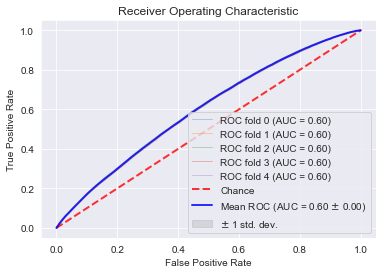

True Negative:  44653
False Positive: 43680
False Negative: 30829
True Positive:  57504
              precision    recall  f1-score   support

         0.0       0.59      0.51      0.55     88333
         1.0       0.57      0.65      0.61     88333

    accuracy                           0.58    176666
   macro avg       0.58      0.58      0.58    176666
weighted avg       0.58      0.58      0.58    176666

Wall time: 3min 13s


array([[44653, 43680],
       [30829, 57504]], dtype=int64)

In [31]:
%%time

target_col = '201181'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial1 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial1.fillna(0,inplace=True)
cols = trial1.columns

scalar = MinMaxScaler()
trial1 = pd.DataFrame(scalar.fit_transform(trial1),columns=cols)

# Split into in/dependent vars
trial1_sub = trial1.sample(n=10000,random_state=42)
X = trial1_sub.drop([target_col],axis=1)
y = trial1_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial1_sub,target = target_col,n=20)

# Balance the classes
num_per_class = trial1[target_col].value_counts().min()
trial1 = trial1.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial1.drop([target_col],axis=1)
y = trial1[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()

for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial1[cols_to_keep].values
y_full = trial1[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 999998: Diabetes blood sugar controlled

Optimization terminated successfully.
         Current function value: 0.662604
         Iterations 5


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1,logreg_Coeff,logreg_p-value,OLS_Coeff,OLS_p-value
SPCLST_BENEFIT_PAID_AMT,0.033,14.000,0.013,5.000,1.774,15.000,9.500,-5.115,0.022,-1.247,0.012
EMERG_MBR_PAID_AMT,0.025,20.000,0.000,19.000,1.080,4.000,19.500,-2.415,0.077,-0.490,0.124
YOY_DIFF_LAB,0.031,15.000,0.003,12.000,1.128,7.000,13.500,-1.038,0.000,0.006,0.930
NY_ASC,0.066,3.000,0.032,3.000,2.257,18.000,3.000,-0.839,0.000,-0.181,0.000
Plan_Type_PPO,0.164,1.000,0.055,1.000,23.585,20.000,1.000,-0.797,0.000,-0.065,0.130
NY_INPATIENTSTAYMC,0.056,4.000,0.012,7.000,1.775,16.000,5.500,-0.662,0.001,-0.120,0.009
YOY_DIFF_EMERGENCY,0.026,18.000,0.013,6.000,1.361,12.000,12.000,-0.312,0.108,0.002,0.963
NY_MOOPINN,0.043,8.000,0.002,13.000,1.719,14.000,10.500,-0.304,0.003,-0.051,0.032
Plan_Type_HMO,0.127,2.000,0.052,2.000,23.515,19.000,2.000,-0.289,0.135,0.061,0.152
YOY_DIFF_TIER1PREFRETAIL1MO,0.037,11.000,0.009,9.000,1.082,5.000,10.000,-0.151,0.148,-0.035,0.160


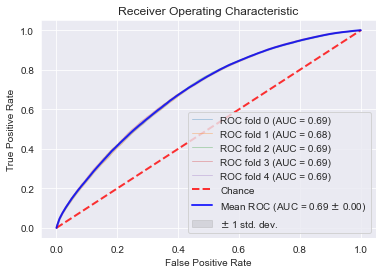

True Negative:  61341
False Positive: 46775
False Negative: 30675
True Positive:  77441
              precision    recall  f1-score   support

         0.0       0.67      0.57      0.61    108116
         1.0       0.62      0.72      0.67    108116

    accuracy                           0.64    216232
   macro avg       0.65      0.64      0.64    216232
weighted avg       0.65      0.64      0.64    216232

Wall time: 3min 38s


array([[61341, 46775],
       [30675, 77441]], dtype=int64)

In [32]:
%%time

target_col = '999998'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial2 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial2.fillna(0,inplace=True)
cols = trial2.columns

scalar = MinMaxScaler()
trial2 = pd.DataFrame(scalar.fit_transform(trial2),columns=cols)

# Split into in/dependent vars
trial2_sub = trial2.sample(n=10000,random_state=42)
X = trial2_sub.drop([target_col],axis=1)
y = trial2_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial2_sub,target = target_col)

# Balance the classes
num_per_class = trial2[target_col].value_counts().min()
trial2 = trial2.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial2.drop([target_col],axis=1)
y = trial2[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial2[cols_to_keep].values
y_full = trial2[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 201183: Statin Use in Diabetes

Optimization terminated successfully.
         Current function value: 0.466261
         Iterations 7


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1,logreg_Coeff,logreg_p-value,OLS_Coeff,OLS_p-value
AETNA_MED_PAID_AMT,0.058,4.000,0.004,6.000,2.456,18.000,5.000,-3.912,0.094,-0.721,0.036
EMERG_MBR_PAID_AMT,0.033,18.000,0.000,18.000,1.079,9.000,18.000,-1.586,0.139,-0.206,0.211
SPCLST_MBR_PAID_AMT,0.051,13.000,0.002,10.000,2.330,17.000,11.500,-1.433,0.151,-0.198,0.149
PCP_BENEFIT_PAID_AMT,0.054,7.000,0.015,1.000,1.452,14.000,4.000,-1.203,0.829,-0.187,0.803
NY_TIER1PREFRETAIL1MO,0.064,3.000,0.000,18.000,1.541,15.000,10.500,-0.306,0.105,-0.026,0.359
YOY_DIFF_TIER1PREFRETAIL1MO,0.070,1.000,0.004,5.000,1.436,13.000,3.000,-0.278,0.073,-0.024,0.277
NY_TIER2PREFRETAIL3MO,0.053,9.000,0.004,7.000,1.146,10.000,8.000,-0.124,0.107,-0.007,0.537
YOY_DIFF_PCP,0.055,6.000,0.000,15.000,1.161,12.000,10.500,-0.039,0.852,0.125,0.000
NY_PREMIUM,0.031,19.000,0.000,18.000,1.053,6.000,18.500,0.103,0.634,0.027,0.389
Gender_M,0.045,17.000,0.008,3.000,1.008,1.000,10.000,0.201,0.000,0.037,0.000


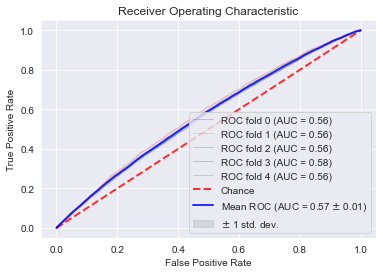

True Negative:  20796
False Positive: 15477
False Negative: 15085
True Positive:  21188
              precision    recall  f1-score   support

         0.0       0.58      0.57      0.58     36273
         1.0       0.58      0.58      0.58     36273

    accuracy                           0.58     72546
   macro avg       0.58      0.58      0.58     72546
weighted avg       0.58      0.58      0.58     72546

Wall time: 2min 19s


array([[20796, 15477],
       [15085, 21188]], dtype=int64)

In [33]:
%%time

target_col = '201183'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial3 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial3.fillna(0,inplace=True)
cols = trial3.columns

scalar = MinMaxScaler()
trial3 = pd.DataFrame(scalar.fit_transform(trial3),columns=cols)

# Split into in/dependent vars
trial3_sub = trial3.sample(n=10000,random_state=42)
X = trial3_sub.drop([target_col],axis=1)
y = trial3_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial3_sub,target = target_col)

# Balance the classes
num_per_class = trial3[target_col].value_counts().min()
trial3 = trial3.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial3.drop([target_col],axis=1)
y = trial3[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial3[cols_to_keep].values
y_full = trial3[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 201182: Diabetes Adherence

Optimization terminated successfully.
         Current function value: 0.411683
         Iterations 7


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1,logreg_Coeff,logreg_p-value,OLS_Coeff,OLS_p-value
IP_BENEFIT_PAID_AMT,0.044,15.000,0.012,4.000,3.418,17.000,9.500,-12.139,0.015,-0.250,0.621
MBR_MED_PAID_AMT,0.055,8.000,0.002,14.000,2.738,16.000,11.000,-2.032,0.006,-0.243,0.014
NY_LAB,0.027,19.000,0.000,18.500,1.055,3.000,18.750,-0.446,0.103,-0.049,0.177
YOY_DIFF_TIER2PREFRETAIL3MO,0.059,5.000,0.004,9.000,39.147,19.000,7.000,-0.205,0.854,0.124,0.364
NY_RXDEDUCTIBLE,0.068,2.000,0.000,18.500,1.382,12.000,10.250,-0.180,0.120,0.017,0.256
NY_PREMIUM,0.039,17.000,0.000,18.500,1.087,6.000,17.750,-0.107,0.624,0.014,0.617
NY_TIER2PREFRETAIL3MO,0.060,4.000,0.014,2.000,2.581,15.000,3.000,-0.078,0.546,-0.048,0.002
YOY_DIFF_TIER1PREFRETAIL1MO,0.040,16.000,0.006,7.000,1.138,9.000,11.500,-0.068,0.645,0.016,0.391
YOY_DIFF_HIGHDEDUCTIBLE_Yes | Yes,0.053,10.000,0.000,16.000,1.062,5.000,13.000,-0.015,0.884,0.003,0.802
Gender_M,0.052,11.000,0.003,13.000,1.005,1.000,12.000,0.116,0.041,0.024,0.001


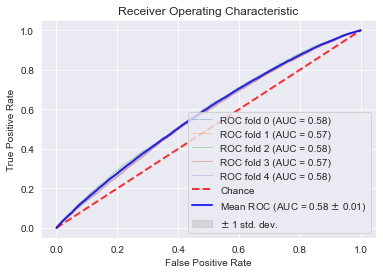

True Negative:  18269
False Positive: 16508
False Negative: 12319
True Positive:  22458
              precision    recall  f1-score   support

         0.0       0.60      0.53      0.56     34777
         1.0       0.58      0.65      0.61     34777

    accuracy                           0.59     69554
   macro avg       0.59      0.59      0.58     69554
weighted avg       0.59      0.59      0.58     69554

Wall time: 2min 29s


array([[18269, 16508],
       [12319, 22458]], dtype=int64)

In [34]:
%%time

target_col = '201182'
drop_list = [i for i in TARGET_COLS if i != target_col]
trial4 = trial[trial[target_col].notnull()].drop(drop_list,axis=1)
trial4.fillna(0,inplace=True)
cols = trial4.columns

scalar = MinMaxScaler()
trial4 = pd.DataFrame(scalar.fit_transform(trial4),columns=cols)

# Split into in/dependent vars
trial4_sub = trial4.sample(n=10000,random_state=42)
X = trial4_sub.drop([target_col],axis=1)
y = trial4_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial4_sub,target = target_col)

# Balance the classes
num_per_class = trial4[target_col].value_counts().min()
trial4 = trial4.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial4.drop([target_col],axis=1)
y = trial4[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial4[cols_to_keep].values
y_full = trial4[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)


### 999998: Composite Diabetes

Optimization terminated successfully.
         Current function value: 0.195580
         Iterations 8


,FI,FI - rank,IV,IV - rank,VIF,VIF - rank,r1,logreg_Coeff,logreg_p-value,OLS_Coeff,OLS_p-value
IP_BENEFIT_PAID_AMT,0.041,12.000,0.012,8.000,3.681,17.000,10.000,-7.971,0.453,0.087,0.840
Age,0.209,1.000,0.200,1.000,1.028,3.000,1.000,-5.369,0.000,-0.224,0.000
PRIMARY_CARE_VISITS,0.049,6.000,0.007,11.000,2.296,15.000,8.500,-2.677,0.385,-0.157,0.314
AETNA_MED_PAID_AMT,0.044,11.000,0.006,12.000,5.772,18.000,11.500,-2.399,0.769,-0.412,0.268
YOY_DIFF_TIER2PREFRETAIL3MO,0.048,7.000,0.005,13.000,33.177,19.000,10.000,-1.569,0.348,-0.046,0.555
NY_ASC,0.038,14.000,0.036,2.000,1.919,13.000,8.000,-0.884,0.045,-0.026,0.210
NY_PREMIUM,0.029,17.000,0.000,19.000,1.066,5.000,18.000,-0.651,0.092,-0.019,0.235
NY_OUTPATIENTHOSP,0.047,8.000,0.036,3.000,1.715,11.000,5.500,-0.585,0.010,-0.030,0.007
YOY_DIFF_LAB,0.054,5.000,0.000,17.000,1.251,9.000,11.000,-0.248,0.689,0.125,0.000
MBR_MED_PAID_AMT,0.046,10.000,0.001,16.000,2.491,16.000,13.000,-0.218,0.910,0.044,0.617


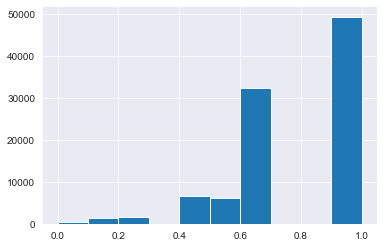

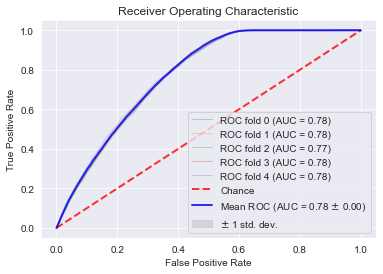

True Negative:  22746
False Positive: 20123
False Negative: 3291
True Positive:  39578
              precision    recall  f1-score   support

         0.0       0.87      0.53      0.66     42869
         1.0       0.66      0.92      0.77     42869

    accuracy                           0.73     85738
   macro avg       0.77      0.73      0.72     85738
weighted avg       0.77      0.73      0.72     85738



array([[22746, 20123],
       [ 3291, 39578]], dtype=int64)

In [37]:
trial['composite_diabetes'] = ((3 * trial['201181']) + (3 * trial['999998']) + (3 * trial['201182']) + (1 * trial['201183']))/10
print(trial['composite_diabetes'].value_counts(dropna=False))
print(trial['composite_diabetes'].describe())
trial['composite_diabetes'].hist()

# Transform y to binary
trial['composite_diabetes'] = trial['composite_diabetes'].apply(lambda x: 1 if float(x) == 1.0 else 0)

trial5 = trial.drop(TARGET_COLS,axis=1)
trial5 = trial5.dropna(subset=['composite_diabetes'])
trial5.fillna(0,inplace=True)

target_col = 'composite_diabetes'

cols = trial5.columns

scalar = MinMaxScaler()
trial5 = pd.DataFrame(scalar.fit_transform(trial5),columns=cols)

# Split into in/dependent vars
trial5_sub = trial5.sample(n=10000,random_state=42)
X = trial5_sub.drop([target_col],axis=1)
y = trial5_sub[target_col]

cols_to_keep,dfr = find_best_cols(X,y,trial5_sub,target = target_col)

# Balance the classes
num_per_class = trial5[target_col].value_counts().min()
trial5 = trial5.sample(frac=1,random_state=42).groupby(target_col).head(num_per_class)

X = trial5.drop([target_col],axis=1)
y = trial5[target_col]

X = X[cols_to_keep]

X = X.values
y = y.values

n_samples,n_features = X.shape
random_state = np.random.RandomState(42)
cv = StratifiedKFold(n_splits=5)
clf = XGBClassifier(random_state = 42,
                   n_jobs=-1,
                   max_depth=3,
                   n_estimators = 400,
                   learning_rate = 0.1,
                   min_child_weight = 4)

tprs,aucs = [],[]
mean_fpr = np.linspace(0,1,100)

fig,ax = plt.subplots()
for i, (train,test) in enumerate(cv.split(X,y)):
    clf.fit(X[train],y[train],eval_metric='error')
    viz = plot_roc_curve(clf,X[test],y[test],name = 'ROC fold {}'.format(i),alpha=0.3,lw=1,ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()

X_full = trial5[cols_to_keep].values
y_full = trial5[target_col]

y_true = y_full
y_pred = clf.predict(X_full)
tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
print(f'True Negative:  {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive:  {tp}')
print(classification_report(y_true,y_pred))
confusion_matrix(y_true,y_pred)